    Imports :

In [2]:
from sklearn.datasets import fetch_california_housing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import t
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

    1)

    1.a)

In [3]:
# uploading fetch_california_housing dataset from sklearn 
housing = fetch_california_housing()
print(housing.data.shape)

(20640, 8)


In [4]:
'''Function to compute the MSE '''
def MSE(y, y_pred):
    return np.mean((y - y_pred)**2)


'''Function to compute the R2 coeff'''
def R2(y, y_pred):
    return 1 - np.sum((y - y_pred)**2)/np.sum((y - np.mean(y))**2)

In [5]:
# Estimating the coefficients using the normal equation
X = np.c_[np.ones(housing.data.shape[0]), housing.data]
y = housing.target.reshape(-1, 1)


theta = np.linalg.inv(X.T @ X).dot(X.T).dot(y)

y_pred = X @ theta

In [6]:
# Computing the MSE and R2
print('MSE: ', MSE(y, y_pred))
print('R2: ', R2(y, y_pred))

MSE:  0.5243209861846072
R2:  0.606232685199805


In [7]:
# Estimating the coefficients using the version of sklearn
reg = LinearRegression().fit(X, y)

# table to resume the results
print('Results :')
results = pd.DataFrame({'MSE': [MSE(y, y_pred), mean_squared_error(y, reg.predict(X))],'R2': [R2(y, y_pred), r2_score(y, reg.predict(X))]}, index=['Normal Equation', 'Sklearn'])
print(results)

Results :
                      MSE        R2
Normal Equation  0.524321  0.606233
Sklearn          0.524321  0.606233


We can see that we have exactly the same values.

    1.b)

In [8]:
# Confidence intervals at level 99% for the coefficients

alpha = 0.01

n = X.shape[0]
p = X.shape[1] - 1

sigma2 = np.sum((y - X @ theta)**2) / (n-p-1)
sigma = np.sqrt(sigma2)

s2 = np.linalg.inv(X.T @ X)

quantile = t.ppf(1-(alpha/2), n-p-1)

CI = [[] for i in range(p+1)]

for i in range(p+1):
    CI[i].append(theta[i] - quantile * np.sqrt(s2[i, i]) * sigma)
    CI[i].append(theta[i] +  quantile * np.sqrt(s2[i, i]) * sigma)

print('Confidence intervals at level 99% for the coefficients:')
# table to resume the results
results = pd.DataFrame({'Theta': theta.reshape(-1), 'CI': CI}, index=['Intercept'] + housing.feature_names)
print(results)


Confidence intervals at level 99% for the coefficients:
                Theta                                                 CI
Intercept  -36.941920       [[-38.63927655710691], [-35.24456386080695]]
MedInc       0.436693       [[0.4258820451255816], [0.4475045411353814]]
HouseAge     0.009436   [[0.008286131981550527], [0.010585424084265962]]
AveRooms    -0.107322   [[-0.12248317645989713], [-0.09216090631483174]]
AveBedrms    0.645066       [[0.5725881772729909], [0.7175432097466447]]
Population  -0.000004  [[-1.6210645744219326e-05], [8.257866899950705...
AveOccup    -0.003787  [[-0.005042156283624906], [-0.0025309290262242...
Latitude    -0.421314   [[-0.43985399170088146], [-0.40277476338996465]]
Longitude   -0.434514      [[-0.4539189890978979], [-0.415108520292601]]


    2)

    2.a)

In [9]:
np.random.seed(0)

In [10]:
new_data = pd.read_csv('data.csv', header=None)

X = np.array(new_data.iloc[:,:-1])
y = np.array(new_data.iloc[:,-1]).reshape(-1, 1)

    2.b)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)

print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)


X_train shape:  (331, 210)
y_train shape:  (331, 1)
X_test shape:  (111, 210)
y_test shape:  (111, 1)


    2.c)

In [12]:
# Regular OLS
reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

MSE_OLS_test = MSE(y_test, y_pred)
R2_OLS_test = r2_score(y_test, y_pred)

MSE_OLS_train = MSE(y_train, reg.predict(X_train))
R2_OLS_train = r2_score(y_train, reg.predict(X_train))

print('MSE: ', MSE_OLS_test)
print('R2: ', R2_OLS_test)

MSE:  0.7730710160988391
R2:  0.02619321536922492


    3) Variable selection :

    3.a)

In [13]:
''' Function fiting p linear regression models and returning the smallest p-value, the index of the best model and the corresponding coefficient'''
def fit_p_models(X, y):
    """
    X: matrix of features, reduced design matrix
    """
    p = X.shape[1]

    n = X.shape[0]
    # no intercept is used for this regression : the data set is centered
    reg = LinearRegression(fit_intercept = False)

    # test of the hypothesis H0: theta_j = 0
    p_values = []
    coeffs = []
    # fitting p linear regression models
    for i in range(p):
        X_i = X[:, i].reshape(-1, 1)
        reg.fit(X_i, y)

        coeff = reg.coef_[0][0]
        coeffs.append(coeff)

        residuals =  y - reg.predict(X_i)
        sn = np.sqrt(X_i.shape[0] / (X_i.T @ X_i))[0][0]

        stat = coeff * np.sqrt(n) / ( np.std(residuals, ddof=1) * sn ) # np.sqrt(X_i.shape[0])
        ## sigma_x_snk_2 = ( np.sum(residuals)**2 ) *  n / ( np.sum(X_i**2) * (n-2))

        ### t_ = np.abs(coeff) / np.sqrt(sigma_x_snk_2) 
        ##t_stat.append(t_[0])
        
        p_values.append(2*(1 - t.cdf(np.abs(stat), n-1)))
    
    return np.argmin(p_values), np.min(p_values), coeffs[np.argmin(p_values)]

    3.b) and 3.c)

In [14]:
def forward_variable_selection(X, y):
    """
    X: matrix of features, reduced design matrix
    y: vector of target values

    returns: list of selected features, list of corresponding p-values
    """
    p_values = []
    selected_features = []
    while True:
        index, min_p_value, theta = fit_p_models(X, y)

        if min_p_value < 0.05:
            selected_features.append(X[:, index])
            p_values.append(min_p_value)
            y = y - X[:, index].reshape(-1, 1) * theta
        else:
            break
    
    return selected_features, p_values

X_train_new = X_train.copy()
y_train_new = y_train.copy()
selected_features, p_values = forward_variable_selection(X_train_new, y_train_new)

print('The  number of selected features is: ', len(selected_features))  
print('Some of the p-values are: ', p_values[:5])

The  number of selected features is:  12
Some of the p-values are:  [0.0, 0.0, 6.512230754651682e-09, 2.135798870650518e-06, 0.0003574479367125516]


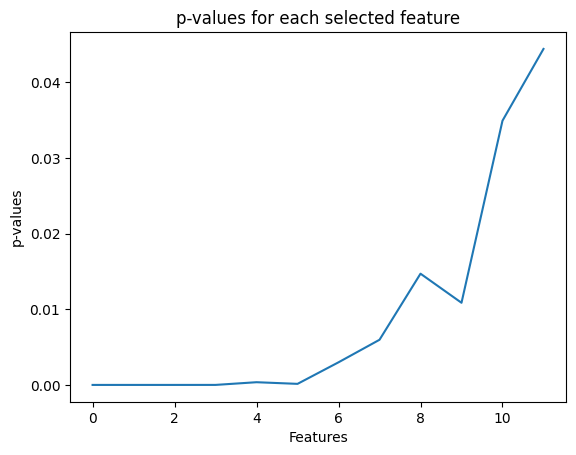

In [15]:
# plotting the first p-values
plt.plot(p_values)
plt.xlabel('Features')
plt.ylabel('p-values')
plt.title('p-values for each selected feature')
plt.show()

The reason for subtracting the predictions or calculating the residuals to construct a new model, ...... 

Remark : Here we cannot keep track of the indexes of the selected features in the original reduced desgin matrix, because the selection is done feature by feature, in a separated function. To get accesses to the indexes of the selected features, I will modify the function to get a single function that does the forward variable selection.

In [16]:
# Forward variable selection 

n = X_train.shape[0]
p = X_train.shape[1]

#add a column for the intercept
ones = np.ones((n,1))
X_train_ones = X_train.copy()

r = y_train
S = [] #variables added
A = [k for k in range(p)] #variables to add

#list of indices mirroring the addition order of the variables
order_addition = []

#initialization of p-values and tests : each line represents a step, and column a p-value/test of a exploratoy variable
T_n = np.zeros((p,p))
p_values = np.zeros((p,p))
p_values_min = np.zeros(p)
# no intercept is used for this regression : the data set is centered
reg = LinearRegression(fit_intercept = False)

print('Forward variable selection :')
for k in range(p): #compute the algorithm p times : no use of the stop criterion, thus goes through each exploratory variable
    residuals = np.zeros((n,p))
    for var in A:
        reg.fit(X_train_ones[:,[var]],r) #Linear regression of Yi 
        
        # Evaluates the residuals between Y and Yi, le linear regression of Y
        residuals[:,var] = (r - reg.predict(X_train_ones[:,[var]])).reshape(-1)
        
        # Works out sigma2
        sigma_x_snk_2 = np.sum(residuals[:,var]**2)/(n-1)*n/np.sum(X_train_ones[:,var]**2)
        
        # Compute the test and the p-value (cf. course) associated to each variable at step k
        T_n[k, var] = (n**0.5) * np.abs(reg.coef_)/np.sqrt(sigma_x_snk_2)
        p_values[k, var] = 2*(1-norm.cdf(T_n[k,var]))
    
    best_var = np.argmax(T_n[k,:]) # selects the variable with the "greatest importance"
    # p-value of the selected variable
    p_values_min[k] = p_values[k,best_var]
    A.remove(best_var) # reduces the set of variables that can be selected
    order_addition.append(best_var)
    r = residuals[:,best_var] 

Forward variable selection :


In [17]:
print('selected features is: ', order_addition)

# p_value
print('p-values are: ', p_values_min[p_values_min < 0.05])

selected features is:  [58, 123, 208, 133, 129, 13, 77, 92, 34, 152, 31, 131, 59, 196, 135, 102, 167, 56, 60, 63, 110, 130, 99, 138, 97, 53, 169, 69, 36, 79, 21, 174, 122, 51, 61, 159, 49, 74, 75, 12, 202, 95, 112, 163, 191, 204, 81, 23, 193, 147, 183, 55, 24, 108, 8, 14, 103, 19, 115, 197, 118, 71, 88, 155, 139, 83, 141, 30, 182, 168, 2, 154, 6, 149, 104, 181, 18, 199, 101, 57, 165, 93, 134, 50, 64, 65, 188, 78, 180, 136, 85, 146, 25, 87, 28, 15, 172, 171, 156, 37, 22, 201, 119, 9, 73, 38, 162, 144, 120, 32, 41, 5, 194, 125, 113, 117, 145, 43, 67, 205, 148, 84, 206, 192, 127, 161, 7, 158, 10, 106, 46, 39, 94, 203, 140, 151, 70, 128, 190, 200, 186, 185, 3, 96, 175, 164, 16, 40, 27, 105, 48, 160, 44, 54, 90, 111, 1, 45, 198, 26, 132, 114, 72, 177, 29, 91, 195, 207, 76, 20, 179, 142, 143, 209, 121, 42, 109, 52, 173, 153, 166, 62, 100, 89, 184, 176, 0, 86, 178, 82, 189, 107, 124, 126, 66, 47, 4, 116, 33, 35, 11, 187, 98, 157, 150, 170, 68, 80, 17, 137]
p-values are:  [0.00000000e+00 2.087

    4) Extensions :

    4.a) and 4.b)

The grid of parameters is:  [1.00000000e-01 1.74332882e-01 3.03919538e-01 5.29831691e-01
 9.23670857e-01 1.61026203e+00 2.80721620e+00 4.89390092e+00
 8.53167852e+00 1.48735211e+01 2.59294380e+01 4.52035366e+01
 7.88046282e+01 1.37382380e+02 2.39502662e+02 4.17531894e+02
 7.27895384e+02 1.26896100e+03 2.21221629e+03 3.85662042e+03
 6.72335754e+03 1.17210230e+04 2.04335972e+04 3.56224789e+04
 6.21016942e+04 1.08263673e+05 1.88739182e+05 3.29034456e+05
 5.73615251e+05 1.00000000e+06]


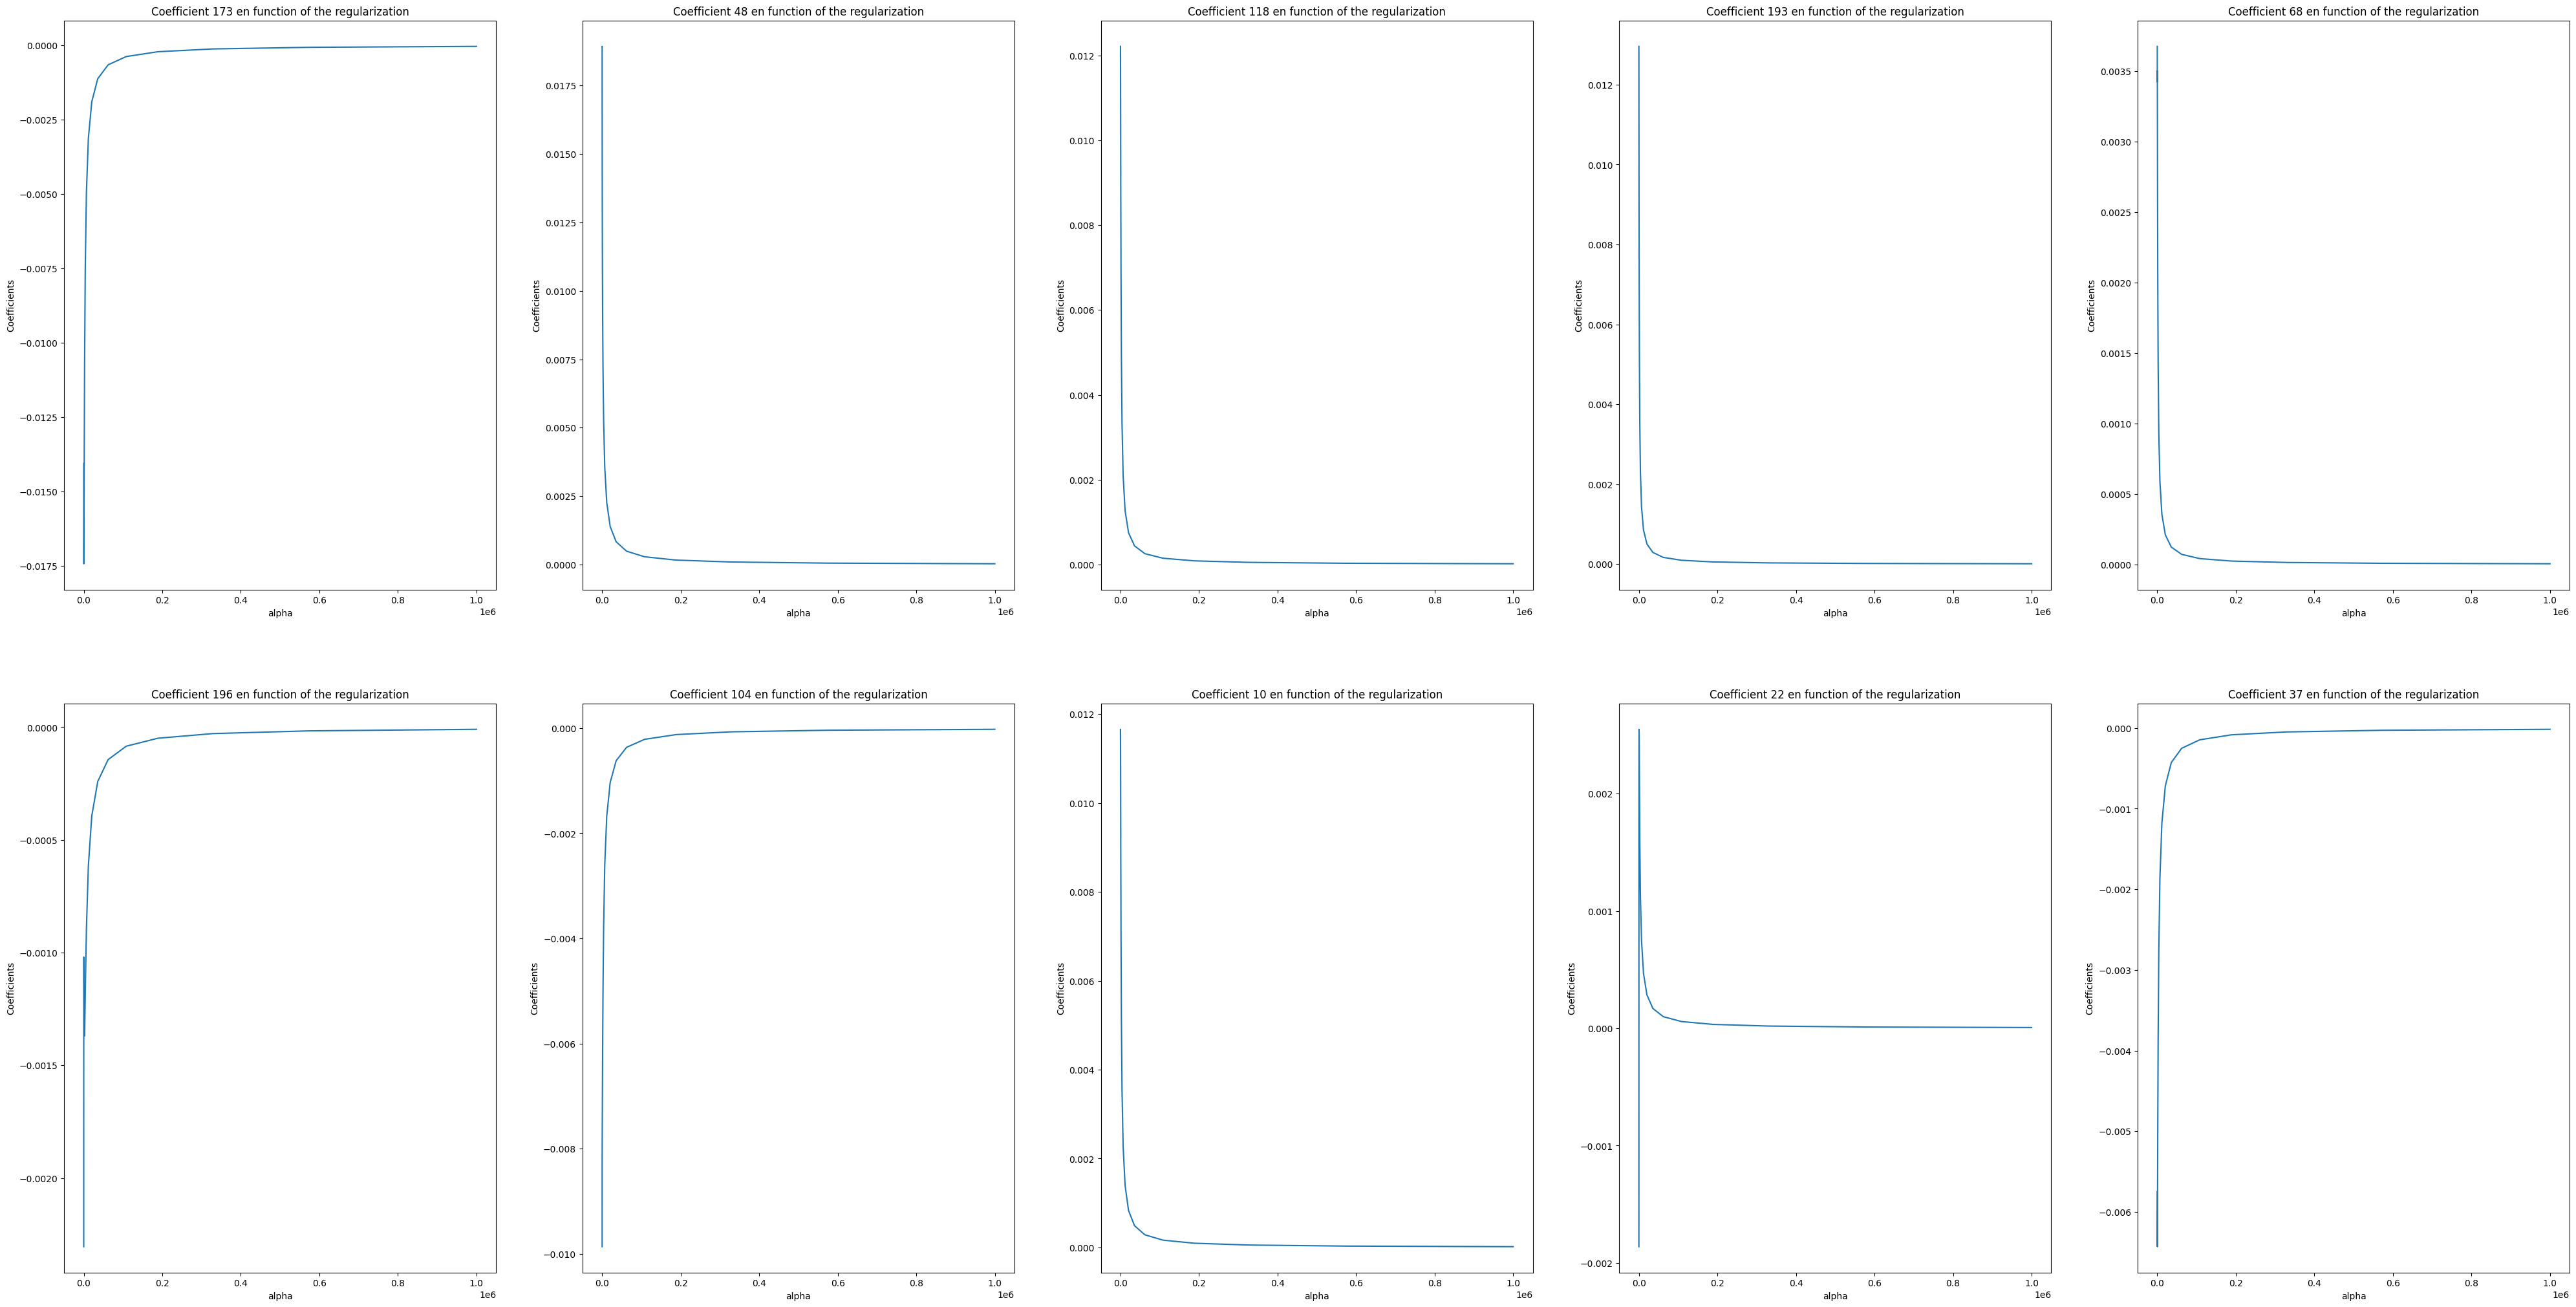

The best R2 is:  [0.31479689023360713, 0.31462993244226056, 0.31436132659992944, 0.31395289123110093, 0.3133874474803894, 0.3127186856518579, 0.3121298491803446, 0.31194778607203455, 0.3125782672076358, 0.3143970433755139, 0.31758515811567056, 0.3217407135867878, 0.3251845720225326, 0.3245379482988817, 0.31581113289702056, 0.2968089735789309, 0.2677600475281945, 0.2295957625138063, 0.18431249774508485, 0.13702133855046006, 0.09448974489387041, 0.06121092915472259, 0.03787013652638216, 0.02270653412009671, 0.013332810166856168, 0.007713381754079873, 0.004406011577343105, 0.00248038743242629, 0.0013662912931180493, 0.0007240622472619584]


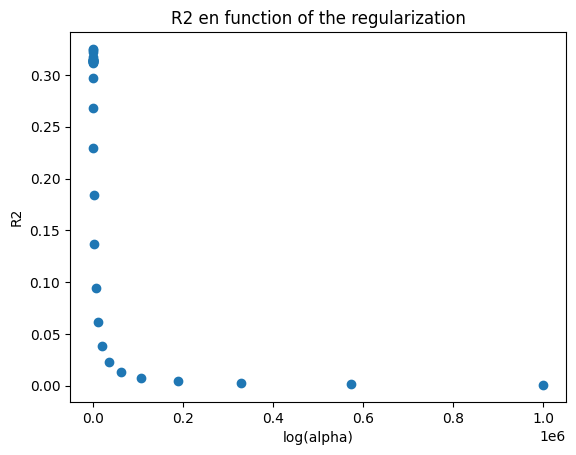

In [18]:
# Ridge regression using scikit-learn

def param_reg(X_train, y_train, model, param_grid):

    print('The grid of parameters is: ', param_grid)
    
    # The list of the coefficients
    coefs = []
    R2 = []
    for i in range(30):
        model.set_params(alpha=param_grid[i])
        model.fit(X_train, y_train)
        coefs.append(model.coef_.reshape(-1))
        R2.append(model.score(X_test, y_test))


    return param_grid, np.array(coefs), R2


def displaying(X_train, y_train, model, param_grid):
    
    param_grid, coefs, R2 = param_reg(X_train, y_train, model, param_grid)
    plt.figure(figsize=(50, 80))

    # plotting random of the 210 coefficients
    # 8 wide list of random numbers between 0 and 210
    random = np.random.randint(0, 210, 10)
    k=0
    for i in random:
        plt.subplot(6, 5, k+1)
        plt.plot(param_grid, coefs[:,i])
        plt.xlabel('alpha')
        plt.ylabel('Coefficients')
        plt.title('Coefficient {} en function of the regularization'.format(i+1))
        k+=1
    plt.show()

    print('The best R2 is: ', R2)
    # plotting the R2
    plt.scatter(param_grid, R2)
    plt.xlabel('log(alpha)')
    plt.ylabel('R2')
    plt.title('R2 en function of the regularization')
    plt.show()

ridge = Ridge()
# logaritmic scale
param_grid = np.logspace(-1, 6, 30)

displaying(X_train, y_train, ridge, param_grid)

    We can see that the coefficients always coverge to 0, when lambda increases. This is due to the fact that the Lasso regression is a penalized regression, and the penalty term is proportional to the sum of the absolute values of the coefficients. Thus, the higher the penalty, the lower the coefficients.
    And this has an effect on the R2 score, which decreases when lambda increases. This is due to the fact that the higher the penalty, the more the model is penalized for having high coefficients, and thus the less the model is able to fit the data.

In [19]:
# Selecting the model with the best R2
ridge.set_params(alpha=param_grid[np.argmax(R2)])
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

R2_ridge_test = R2(y_test, y_pred)
MSE_ridge_test = MSE(y_test, y_pred)

R2_ridge_train = ridge.score(X_train, y_train)
MSE_ridge_train = MSE(y_train, ridge.predict(X_train))

    5)

The grid of parameters is:  [1.00000000e-03 1.48735211e-03 2.21221629e-03 3.29034456e-03
 4.89390092e-03 7.27895384e-03 1.08263673e-02 1.61026203e-02
 2.39502662e-02 3.56224789e-02 5.29831691e-02 7.88046282e-02
 1.17210230e-01 1.74332882e-01 2.59294380e-01 3.85662042e-01
 5.73615251e-01 8.53167852e-01 1.26896100e+00 1.88739182e+00
 2.80721620e+00 4.17531894e+00 6.21016942e+00 9.23670857e+00
 1.37382380e+01 2.04335972e+01 3.03919538e+01 4.52035366e+01
 6.72335754e+01 1.00000000e+02]


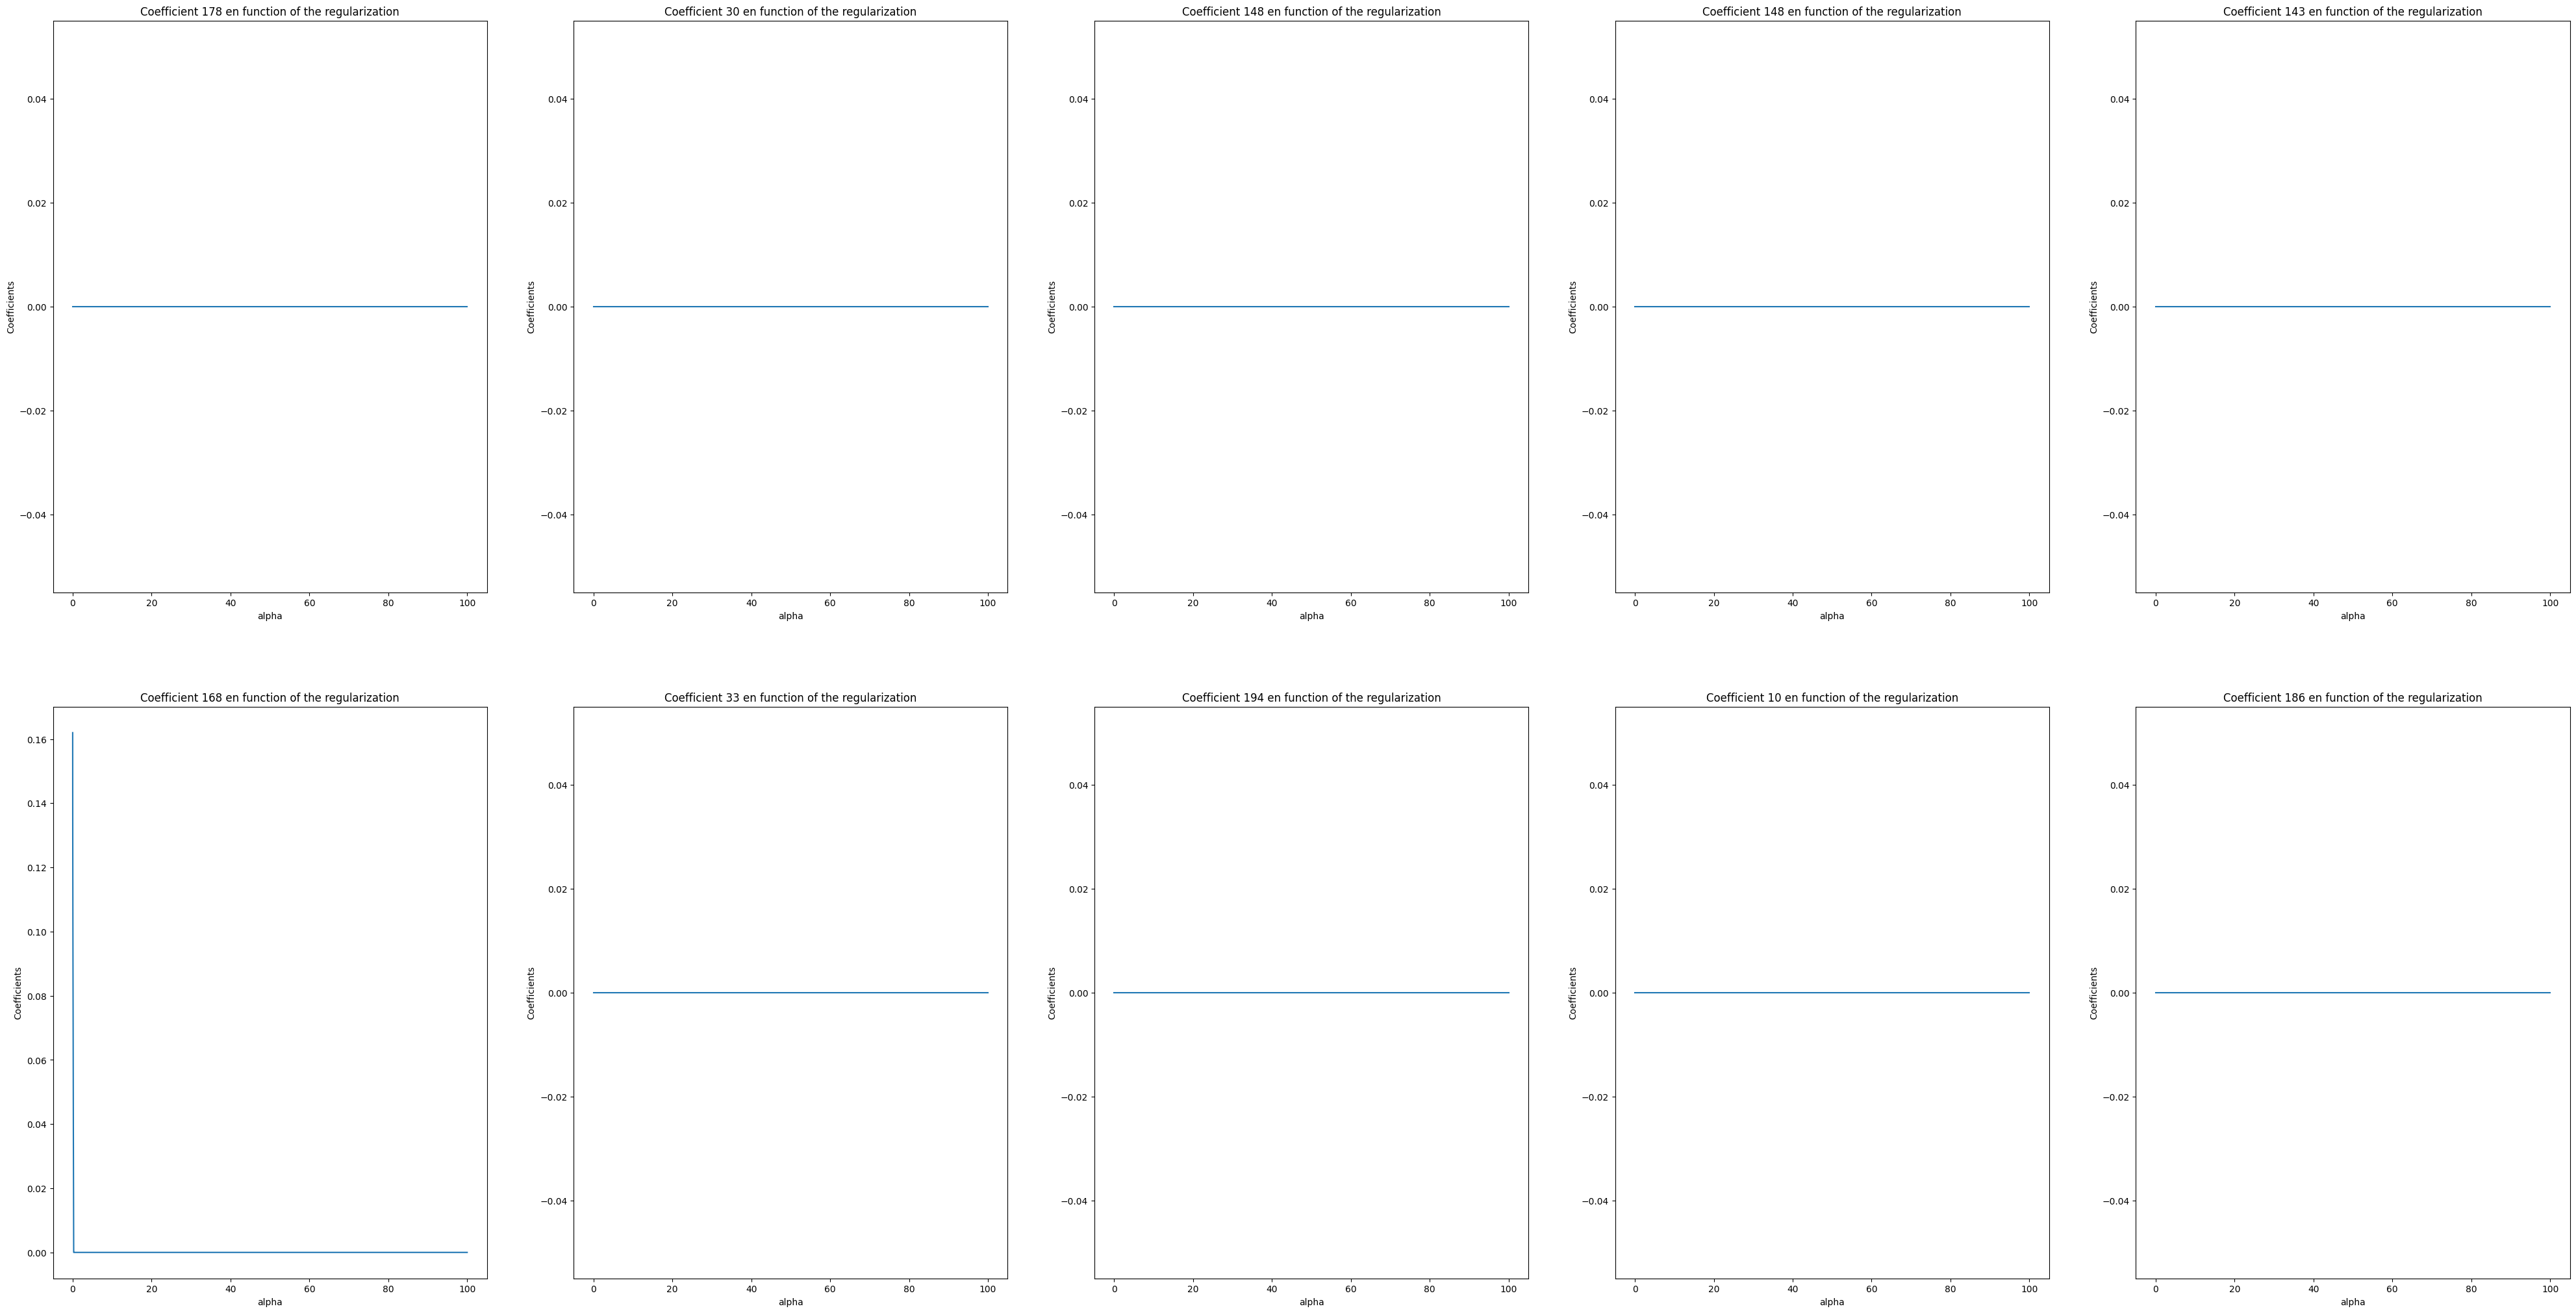

The best R2 is:  [0.3159031296406415, 0.3162953872901435, 0.3169296749929241, 0.3176767462866279, 0.3185327635864209, 0.3192575324332444, 0.32031531131851376, 0.32159371661390157, 0.32777737277141117, 0.3333843495774327, 0.34021322656856856, 0.341750060731403, 0.33365861751856374, 0.3162462350226457, 0.27778989886265204, 0.2128733303121263, 0.043947132445150694, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392]


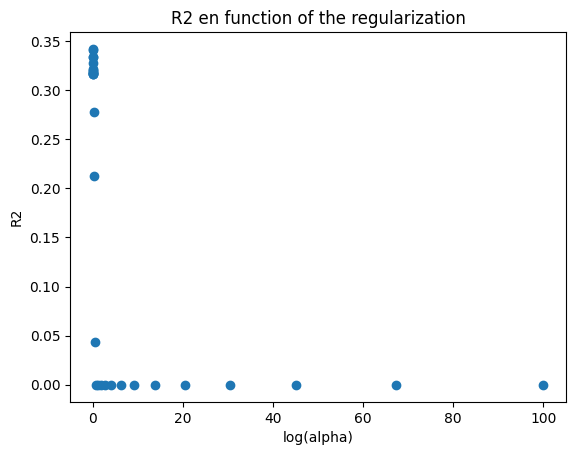

In [20]:
# Lasso
lasso = Lasso()
# logaritmic scale
param_grid = np.logspace(-3, 2, 30)

displaying(X_train, y_train, lasso, param_grid)

In [21]:
# Selecting the model with the best R2
lasso.set_params(alpha=param_grid[np.argmax(R2)])
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

R2_lasso_test = lasso.score(X_test, y_test)
MSE_lasso_test = mean_squared_error(y_pred, y_test)

R2_lasso_train = lasso.score(X_train, y_train)
MSE_lasso_train = mean_squared_error(y_train, lasso.predict(X_train))

    6)

The grid of parameters is:  [1.00000000e-03 1.48735211e-03 2.21221629e-03 3.29034456e-03
 4.89390092e-03 7.27895384e-03 1.08263673e-02 1.61026203e-02
 2.39502662e-02 3.56224789e-02 5.29831691e-02 7.88046282e-02
 1.17210230e-01 1.74332882e-01 2.59294380e-01 3.85662042e-01
 5.73615251e-01 8.53167852e-01 1.26896100e+00 1.88739182e+00
 2.80721620e+00 4.17531894e+00 6.21016942e+00 9.23670857e+00
 1.37382380e+01 2.04335972e+01 3.03919538e+01 4.52035366e+01
 6.72335754e+01 1.00000000e+02]


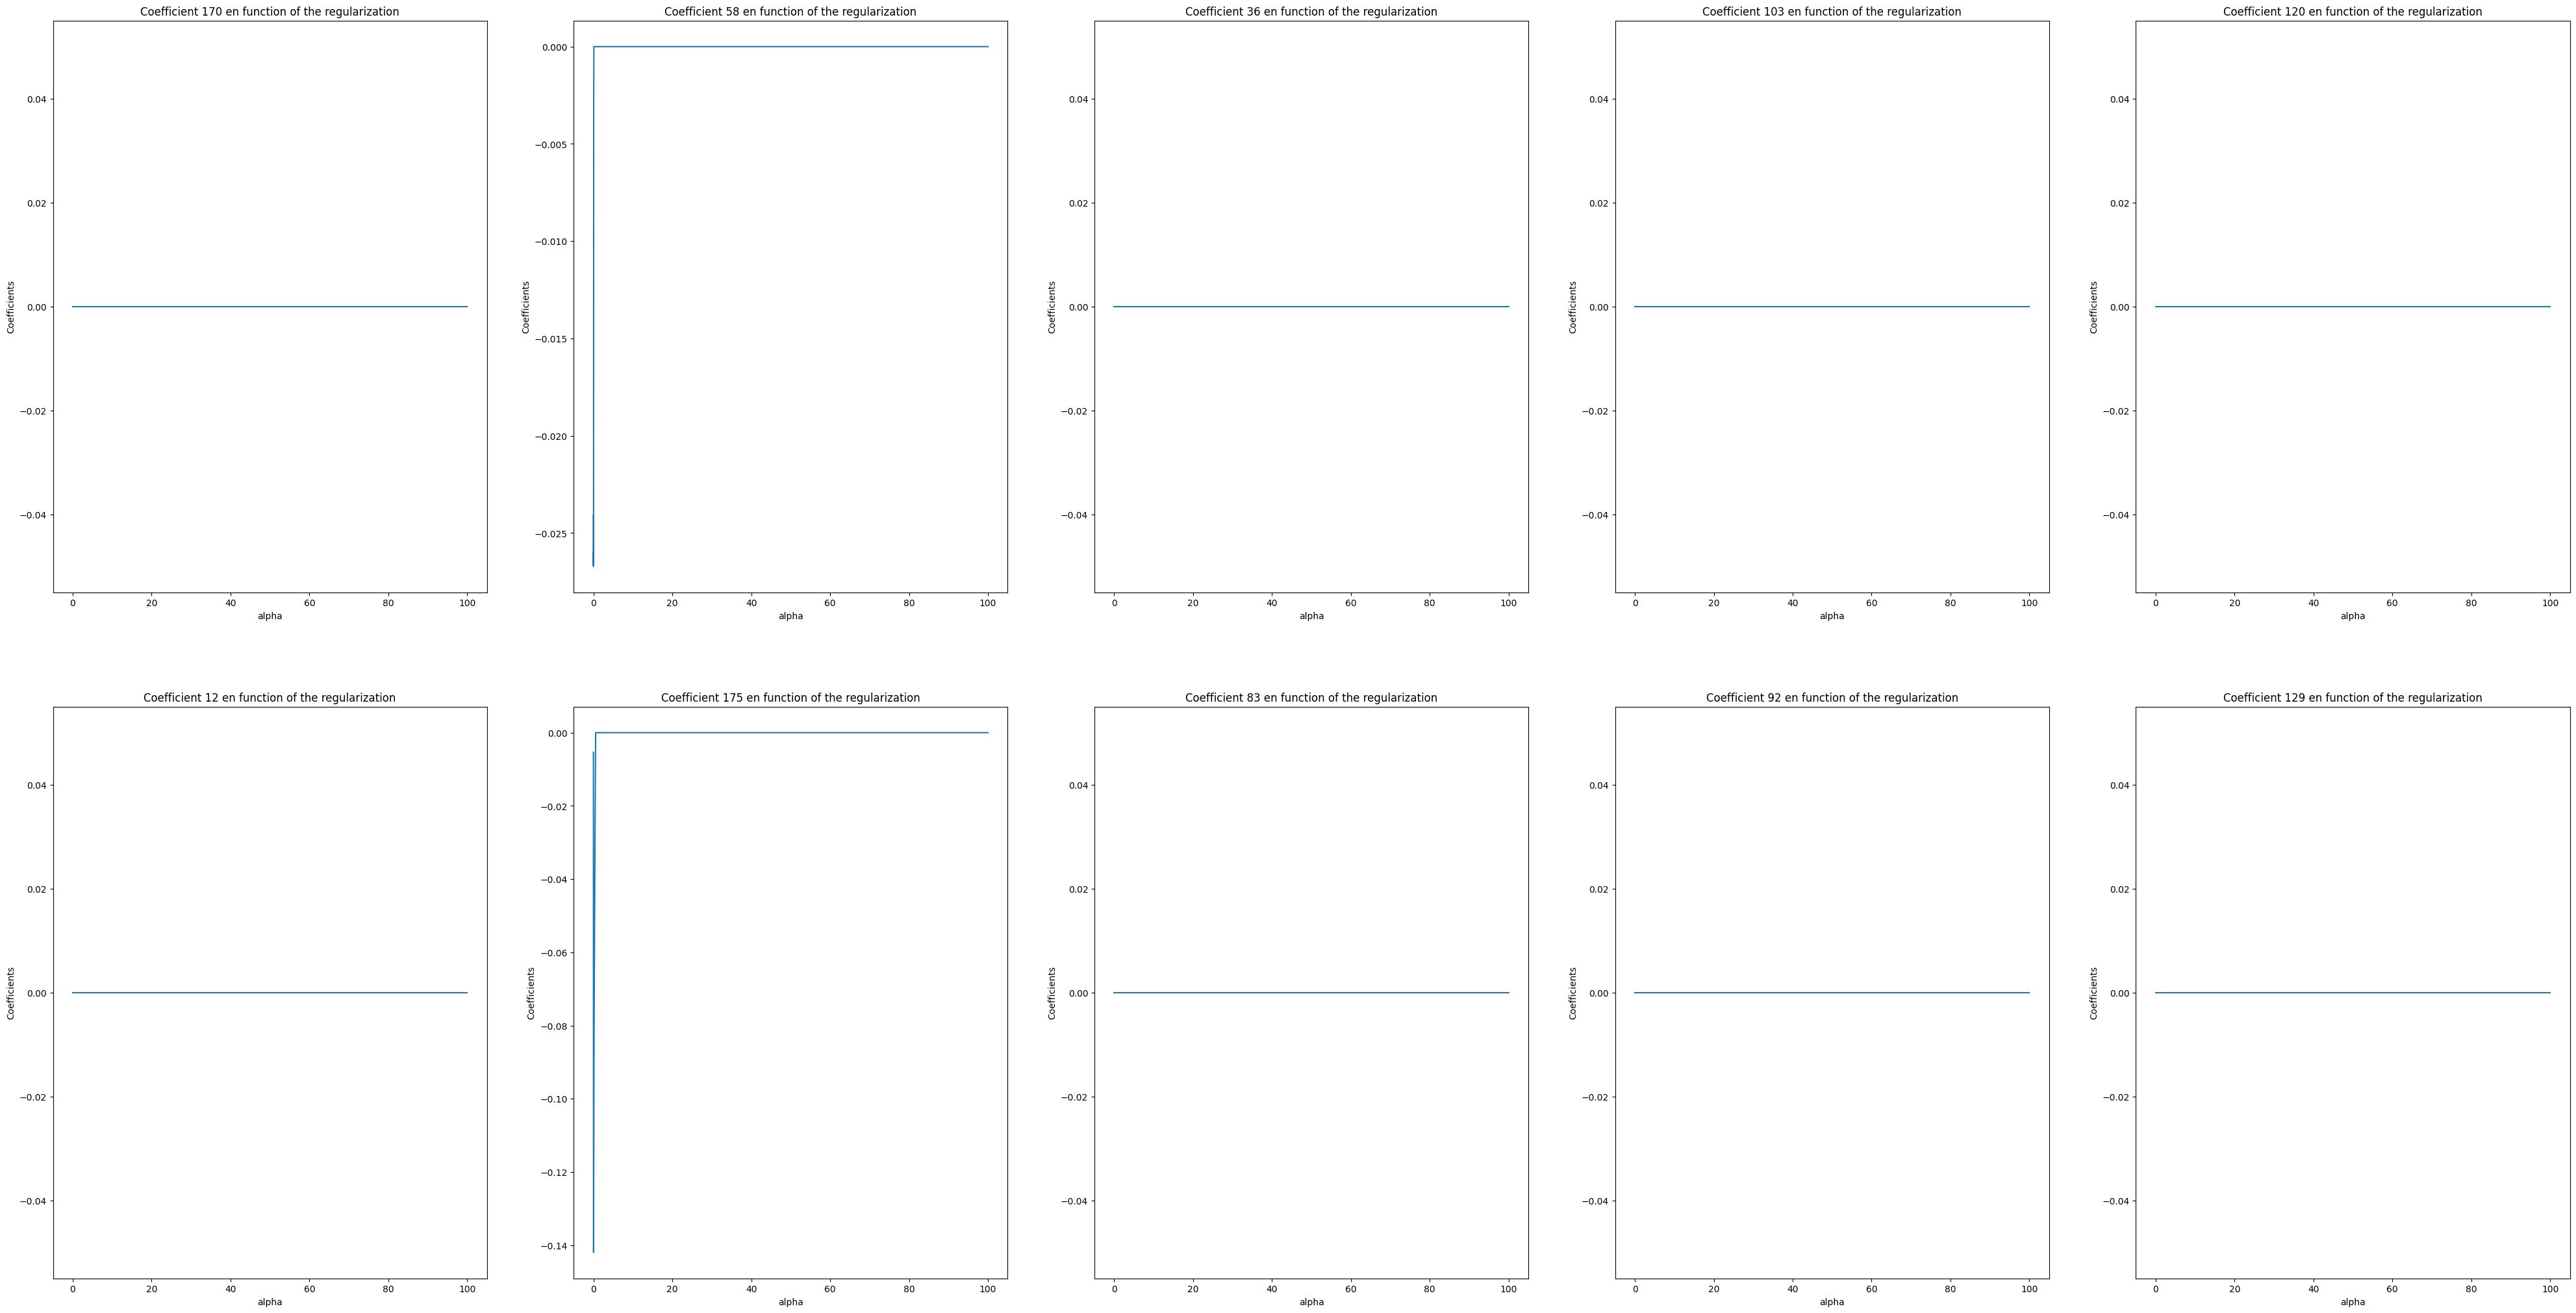

The best R2 is:  [0.31516268258624525, 0.3151896032341909, 0.31529304743291875, 0.31544304566900516, 0.3158846921635088, 0.31665163180734923, 0.3178052333826601, 0.3194317890793352, 0.32144917218627866, 0.3250588828729939, 0.3318442125786397, 0.3387617572497891, 0.34656625920915074, 0.3450671680637072, 0.3353661764247263, 0.3101963386662673, 0.2489614601750244, 0.15007056954970077, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392, -0.00014359578276046392]


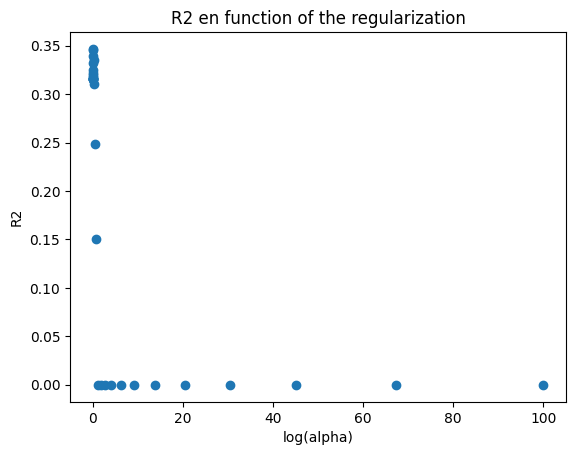

In [22]:
# Elastic Net
elastic = ElasticNet()
# logaritmic scale
param_grid = np.logspace(-3, 2, 30)

displaying(X_train, y_train, elastic, param_grid)

In [23]:
# Selecting the model with the best R2
elastic.set_params(alpha=param_grid[np.argmax(R2)])
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)

R2_elastic_test = elastic.score(X_test, y_test)
MSE_elastic_test = mean_squared_error(y_pred, y_test)

R2_elastic_train = elastic.score(X_train, y_train)
MSE_elastic_train = mean_squared_error(y_train, elastic.predict(X_train))

    Comments on the ridge, Lasso and elasticnet regressions :


    PCA

    7)

In [24]:
# Covariance matrix
cov_mat = X_train.T @ X_train

# SVD
U, s, V = np.linalg.svd(cov_mat)

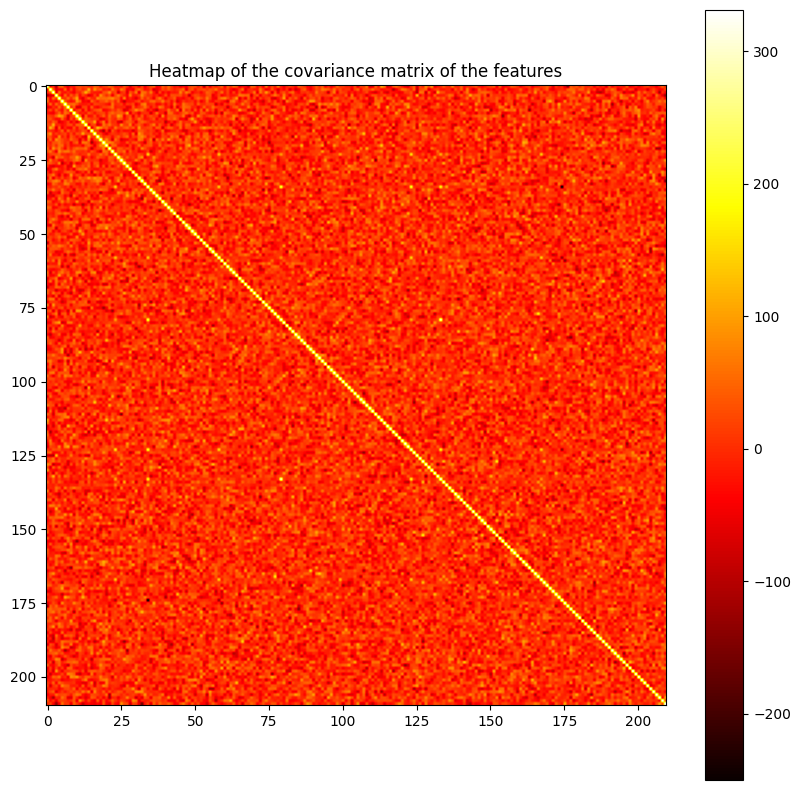

In [25]:
# Heatmap of the covariance matrix
plt.figure(figsize=(10, 10))
plt.imshow(cov_mat, cmap='hot')
plt.colorbar()
plt.title('Heatmap of the covariance matrix of the features')
plt.show()

    7.c)

The amount of variance explained by the first 45 components is:  0.9022221391947608


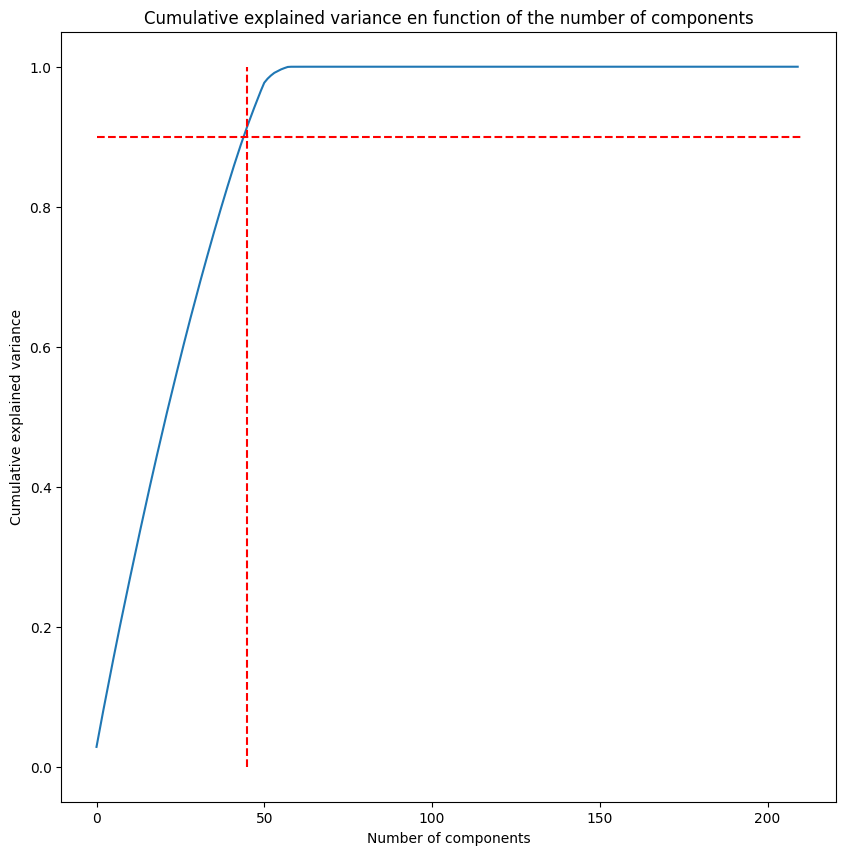

In [26]:
# The amount of variance explained by each of the first k components
k = 45

# The amount of variance explained by the first k components
print('The amount of variance explained by the first {} components is: '.format(k), np.sum(s[:k])/np.sum(s))

# dataFrame ploting the amount of variance explained by each of the first k components
plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(s)/np.sum(s))
# ligne in 0.9
plt.plot([0, 210], [0.9, 0.9], '--', color='red')
# vertical line in k
plt.plot([k, k], [0, 1], '--', color='red')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance en function of the number of components')
plt.show()

    We need 45 components, to explain 90% of the variance. And we can see that ~55 components are enough to explain 99% of the variance.

    7.d)

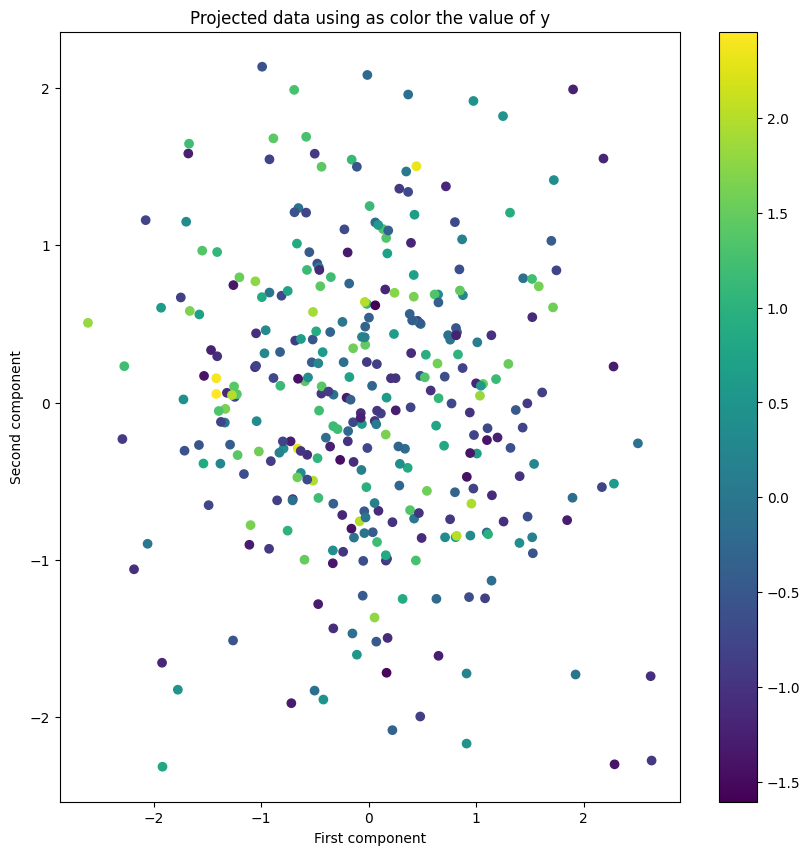

In [27]:
# we will use the first 2 components, Plot the projected data using as color using as color the value of y and interpret the results

# Projecting the data on the first 2 components
X_train_proj = X_train @ V[:2,:].T

# Plotting the projected data using as color using as color the value of y
plt.figure(figsize=(10, 10))
plt.scatter(X_train_proj[:,0], X_train_proj[:,1], c=y_train, cmap='viridis')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title('Projected data using as color the value of y')
plt.colorbar()
plt.show()

    Interpretation : 
    

    7.e)

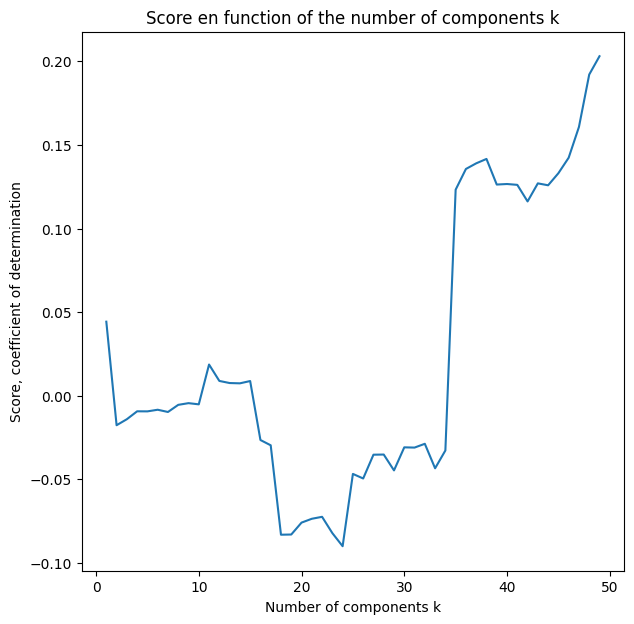

In [28]:
# Runing OLS on the projected data

k = [i for i in range(1, 50)]

# list of scores
scores = []

for i in k:
    # Projecting the data on the first i components
    X_train_proj = X_train @ V[:i,:].T
    X_test_proj = X_test @ V[:i,:].T

    # OLS
    reg = LinearRegression().fit(X_train_proj, y_train)

    # computing the score with test data
    y_pred = reg.predict(X_test_proj)
    scores.append(r2_score(y_test, y_pred))

# Plotting the scores
plt.figure(figsize=(7, 7))
plt.plot(k, scores)
plt.xlabel('Number of components k')
plt.ylabel('Score, coefficient of determination')
plt.title('Score en function of the number of components k')
plt.show()

    The k that returns the best score of the OLS model is necessarily the biggest k, 49 in this case, because the more components we have, the more the model is able to fit the data. And concerning the evolution of the score with k for the OLS model, we can see that, for k > 24, the score increases with k, and then decreases . This is due to the fact that the more components we have, the more the model is able to fit the data, but after a certain number of components, the model starts to overfit the data, and thus the score decreases.
    for k < 24, the score is very low because the model is not able to fit the data, because it doesn't have enough components. ( and we even have negative scores, and that is due to the fact that the model is not able to fit the data, and thus the sum of the squared residuals is bigger than the sum of the squared total, and thus the R2 score is negative.)

    Comparaison of the models :

    8)

In [29]:
# Summary of the results

print('Results on the training set:\n')
results = pd.DataFrame({'MSE': [MSE_OLS_train, MSE_ridge_train, MSE_lasso_train, MSE_elastic_train],
                        'R2': [R2_OLS_train, R2_ridge_train, R2_lasso_train, R2_elastic_train]}, 
                        index=['OLS', 'Ridge', 'Lasso', 'ElasticNet'])

print(results)
print("\n----------------------------------------\n")
print('Results on the test set:\n')
results = pd.DataFrame({'MSE': [MSE_OLS_test, MSE_ridge_test, MSE_lasso_test, MSE_elastic_test],
                        'R2': [R2_OLS_test, R2_ridge_test, R2_lasso_test, R2_elastic_test]}, 
                        index=['OLS', 'Ridge', 'Lasso', 'ElasticNet'])

print(results)

Results on the training set:

                 MSE        R2
OLS         0.494545  0.505455
Ridge       0.381021  0.618979
Lasso       0.381064  0.618936
ElasticNet  0.381037  0.618963

----------------------------------------

Results on the test set:

                 MSE        R2
OLS         0.773071  0.026193
Ridge       0.543959  0.314797
Lasso       0.543080  0.315903
ElasticNet  0.543668  0.315163


    Ridge, Lasso, and ElasticNet outperform OLS on both the training and test sets in terms of both MSE and R2.
    The regularization techniques (Ridge, Lasso, ElasticNet) seem to generalize better to the test set compared to OLS.

    There is a noticeable increase in MSE and decrease in R2 from the training set to the test set for all models. This suggests a degree of overfitting, as the models perform better on the data they were trained on than on unseen data. We can also remark that Ridge, Lasso, and ElasticNet show similar performance on both the training and test sets.

    We can also give the remark that the tuning of the hyperparameters of the regularization techniques (Ridge, Lasso, ElasticNet) is very important, and really helped us choose the best performing model, which made a huge improvement in the performance of the model compared to the regular OLS model.